In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#!pip install stellargraph

!pip install networkx
import networkx as nx

!pip install scikit-plot

import sys
sys.path.append('/content/drive/MyDrive')
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner_ValueLoss, HinSAGE_Representation_Learner_Nrecentfast
import stellargraph as sg

from inductiveGRL.evaluation import Evaluation

from xgboost import XGBClassifier

!pip install shap
import shap 
#shap.initjs()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Read in data 

Read in the data and split it into training and test datasets.

In [2]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train = split_data(data_full, 0, 140)
data_test = split_data(data_full, 141, 180)
inductive_graph_data = pd.concat((data_train, data_test))

## 1.2 Form the Graph

In [3]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
  #print(node_customers.loc["1369566106"])
  node_merchants = dataset[["step", "merchant_id"]].drop_duplicates(subset=["merchant_id"]).set_index("merchant_id")
  # node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.drop_duplicates())

  # transaction node data
  node_txns = dataset[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index), zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S

S = data_to_graph(data_train)
#print(S.info())

## Inductive graph data is train + test data
#inductive_graph_data = pd.concat((data_train, data_test))
#S_ind = data_to_graph(inductive_graph_data)
#print(S_ind.info())

In [4]:
print(data_full.amount, data_full.amount*data_full.fraud)
data_full["mult_label"] = data_full.amount*data_full.fraud
print(data_full.loc[27398])


0          4.55
1         39.68
2         26.89
3         17.25
4         35.72
          ...  
594638    20.53
594639    50.73
594640    22.44
594641    14.46
594642    26.93
Name: amount, Length: 594643, dtype: float64 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
594638    0.0
594639    0.0
594640    0.0
594641    0.0
594642    0.0
Length: 594643, dtype: float64
step                                            10
customer                             'C1572610482'
age                                              3
gender                                         'F'
zipcodeOri                                 '28007'
merchant                             'M1888755466'
zipMerchant                                '28007'
category                          es_otherservices
amount                                      663.05
fraud                                            1
index                                        27398
merchant_id                      

## 1.3 Function that trains and evaluates GraphSAGE for Time window

In [5]:
def train_and_evaluate(start_train_time_step, end_train_time_step, start_test_time_step, end_test_time_step, epochs=1):
  data_train = split_data(data_full, start_train_time_step, end_train_time_step)
  data_test = split_data(data_full, start_test_time_step, end_test_time_step)

  S = data_to_graph(data_train)

  ## Inductive graph data is train + test data
  inductive_graph_data = pd.concat((data_train, data_test))
  S_ind = data_to_graph(inductive_graph_data)

  trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(data_train.index), data_train['fraud'], data_train['amount'], batch_size=5, epochs=epochs)

  inductive_emb = hinsage.inductive_step_hinsage(S_ind, trained_hinsage_model, data_test.index, batch_size=5)
  train_labels = data_train['fraud']
  train_labels_value = data_train['amount']

  add_additional_data = True

  classifier = XGBClassifier(n_estimators=100)
  base_classifier = XGBClassifier(n_estimators=100)

  if add_additional_data is True:
      train_emb_m = pd.merge(train_emb, data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)
      inductive_emb_m = pd.merge(inductive_emb, data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)

      baseline_train = data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]
      baseline_inductive = data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]

      base_classifier.fit(baseline_train, train_labels)
      baseline_predictions = base_classifier.predict_proba(baseline_inductive)

      classifier.fit(train_emb_m, train_labels, sample_weight=train_labels_value)
      predictions = classifier.predict_proba(inductive_emb_m)
      
  else:
    classifier.fit(train_emb, train_labels)
    predictions = classifier.predict_proba(inductive_emb)

  inductive_labels = data_full.loc[inductive_emb.index]['fraud']

  graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
  graphsage_evaluation.pr_curve()

  if add_additional_data is True:
      baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
      baseline_evaluation.pr_curve()
  
  return inductive_labels, baseline_predictions, predictions, inductive_emb, train_emb_m, base_classifier, classifier, baseline_train


In [6]:
def tp_overlap_analysis(labels, baseline_predictions, graph_predictions, txn_data):
  baseline_tp = []
  graph_tp = []
  # get a list of baseline true positives and of graph true positives
  i=0
  for index, value in labels.items():
    # baseline true positives
    if value == baseline_predictions[i] and value == 1:
      baseline_tp.append(index)
    # graph true positives
    if value == graph_predictions[i] and value == 1:
      graph_tp.append(index)
    i = i+1 
  
  # compare id's from besline to graph true positives
  both_count = 0
  both_value = 0
  baseline_only_count = 0
  baseline_only_value = 0
  baseline_only_indexes = []
  for baseline_index in baseline_tp:
    if baseline_index in graph_tp:
      both_count += 1
      both_value += txn_data.loc[baseline_index, "amount"]
    else:
      baseline_only_count += 1
      baseline_only_value += txn_data.loc[baseline_index, "amount"]
      baseline_only_indexes.append(baseline_index)
  graph_only_count = 0
  graph_only_value = 0
  graph_only_indexes = []
  graph_both_count = 0
  for graph_index in graph_tp:
    if graph_index in baseline_tp:
      graph_both_count += 1
    else:
      graph_only_count += 1
      graph_only_value += txn_data.loc[graph_index, "amount"]
      graph_only_indexes.append(graph_index)
  
  print("Number of overlapping transactions:", both_count)
  print("Number of baseline only transactions:", baseline_only_count)
  print("Number of GraphSAGE+features only transactions:", graph_only_count)
  print()
  total_TPs = both_count+baseline_only_count+graph_only_count
  print("Total number of TP transactions identified:", total_TPs)
  print("Percentage of overlapping transactions:", 100*both_count/total_TPs)
  print("Percentage of baseline only transactions:", 100*baseline_only_count/total_TPs)
  print("Percentage of GraphSAGE+Features only transactions:", 100*graph_only_count/total_TPs)
  print()
  print("Value of overlapping transactions:", both_value)
  print("Value of baseline only transactions:", baseline_only_value)
  print("Value of GraphSAGE+features transactions:", graph_only_value)
  print()
  total_value = both_value+baseline_only_value+graph_only_value
  print("% Value of overlapping transactions:", 100*both_value/total_value)
  print("% Value of baseline only transactions:", 100*baseline_only_value/total_value)
  print("% Value of GraphSAGE+features transactions:", 100*graph_only_value/total_value)
  print()
  print("Average Value of overlapping transactions:", both_value/(1+both_count))
  print("Average Value of baseline only transactions:", baseline_only_value/(1+baseline_only_count))
  print("Average Value of GraphSAGE+features transactions:", graph_only_value/(1+graph_only_count))
  
  return both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes



# 2.1 NonTemporalBlind Experiment 1


Epoch 1/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0460 - val_loss: 0.0559
Epoch 2/3
72070/72070 [==============================] - 248s 3ms/step - loss: 0.0233 - val_loss: 0.0170
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.9045697049
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 852
Number of baseline only transactions: 89
Number of GraphSAGE+features only transactions: 92

Total number of TP transactions identified: 1033
Percentage of overlapping transactions: 82.4782187802517
Percentage of baseline only transactions: 8.61568247821878
Percentage of GraphSAGE+Features only transactions: 8.906098741529526

Value of overlapping transactions: 692028.4999999999
Value of baseline only transactions: 34887.78
Value of GraphSAGE+features transactions: 18853.23

% Value of overlapping transactions: 92.79388480228964
% Value of baseline only transactions: 

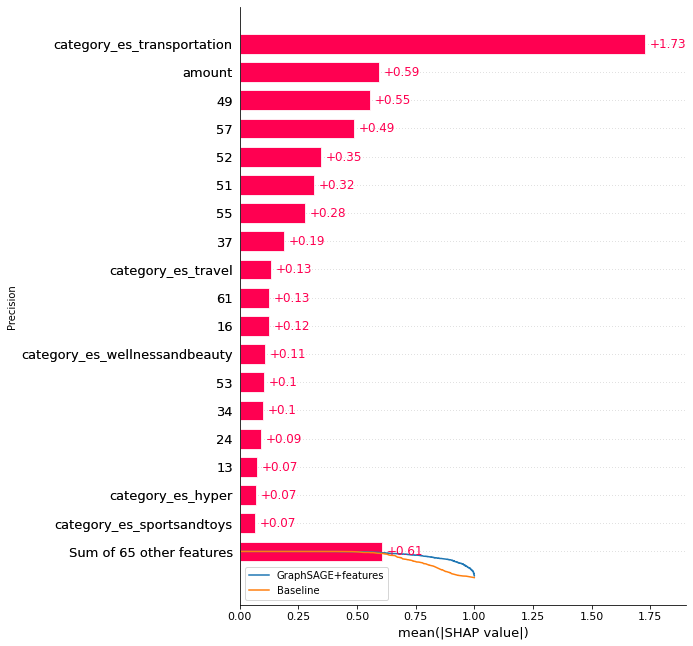

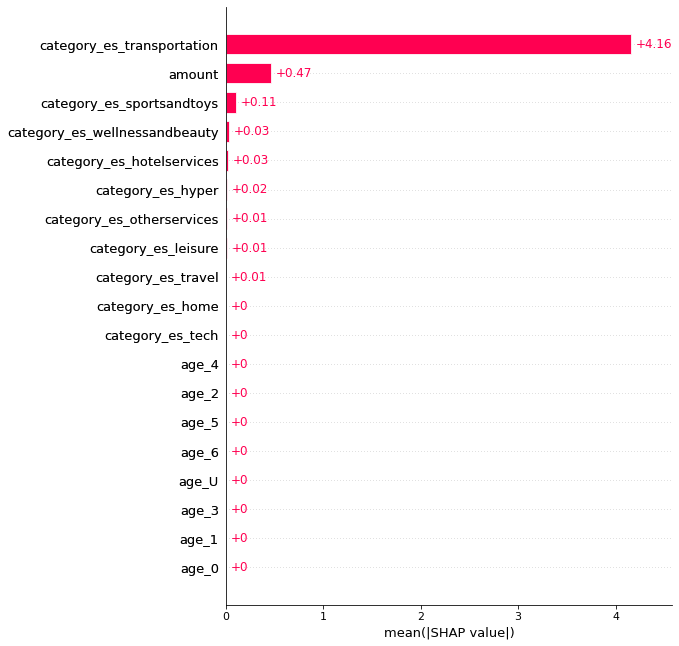

Epoch 1/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0467 - val_loss: 0.0305
Epoch 2/3
72070/72070 [==============================] - 249s 3ms/step - loss: 0.0232 - val_loss: 0.0461
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.9145331477
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 890
Number of baseline only transactions: 51
Number of GraphSAGE+features only transactions: 131

Total number of TP transactions identified: 1072
Percentage of overlapping transactions: 83.0223880597015
Percentage of baseline only transactions: 4.757462686567164
Percentage of GraphSAGE+Features only transactions: 12.220149253731343

Value of overlapping transactions: 711800.0899999995
Value of baseline only transactions: 15116.189999999999
Value of GraphSAGE+features transactions: 25638.47

% Value of overlapping transactions: 94.58449235753281
% Value of baseline only t

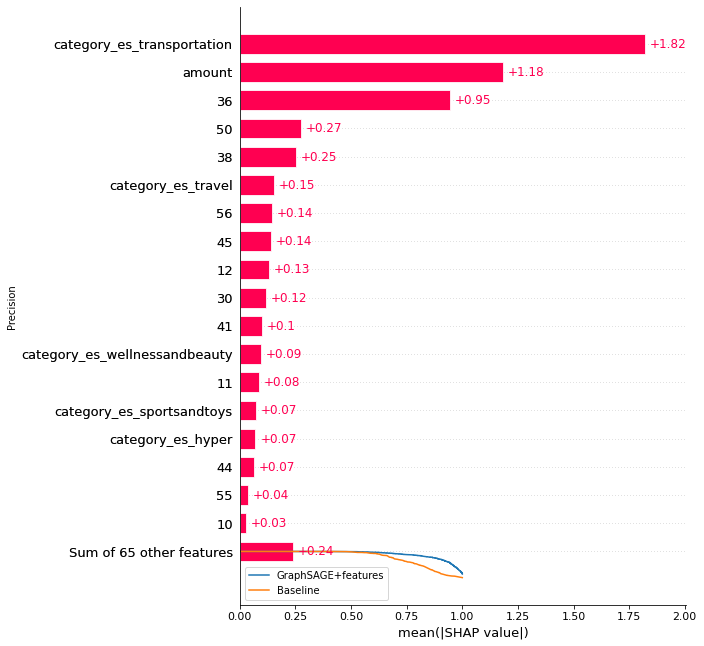

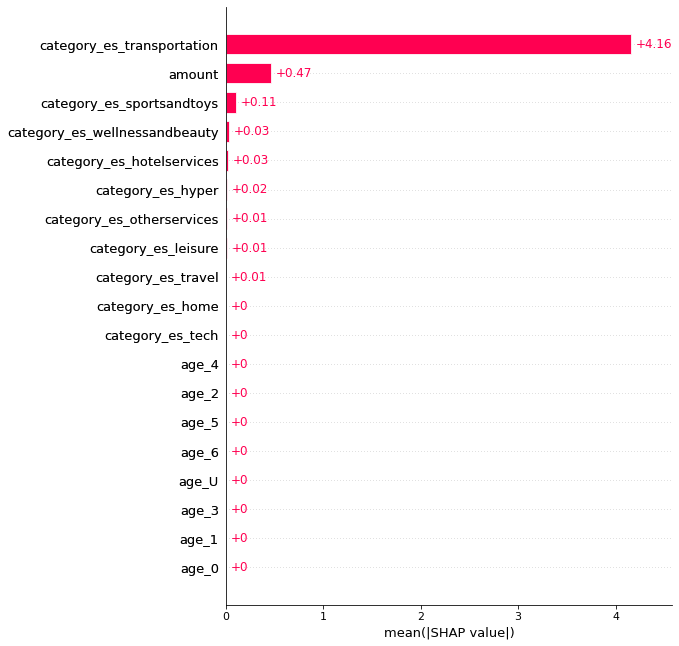

Epoch 1/3
72070/72070 [==============================] - 249s 3ms/step - loss: 0.0438 - val_loss: 0.0373
Epoch 2/3
72070/72070 [==============================] - 249s 3ms/step - loss: 0.0227 - val_loss: 0.0274
Epoch 3/3
28842/28842 [==============================] - 74s 3ms/step
Average precision-recall score XGBoost: 0.9100546586
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 870
Number of baseline only transactions: 71
Number of GraphSAGE+features only transactions: 114

Total number of TP transactions identified: 1055
Percentage of overlapping transactions: 82.46445497630332
Percentage of baseline only transactions: 6.729857819905213
Percentage of GraphSAGE+Features only transactions: 10.80568720379147

Value of overlapping transactions: 703112.0699999997
Value of baseline only transactions: 23804.21
Value of GraphSAGE+features transactions: 22962.350000000002

% Value of overlapping transactions: 93.76344942647586
% Value of baseline only t

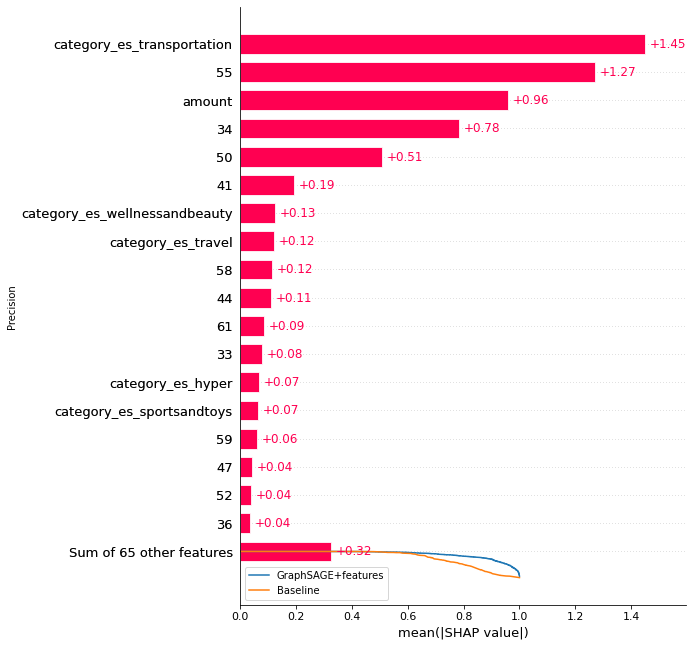

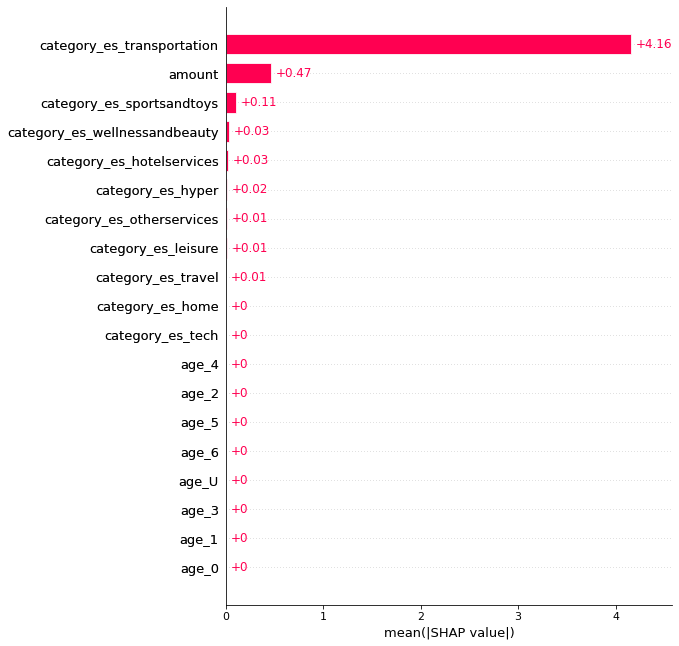

Epoch 1/3
72070/72070 [==============================] - 251s 3ms/step - loss: 0.0442 - val_loss: 0.0331
Epoch 2/3
72070/72070 [==============================] - 277s 4ms/step - loss: 0.0233 - val_loss: 0.0200
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.9157393167
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 883
Number of baseline only transactions: 58
Number of GraphSAGE+features only transactions: 107

Total number of TP transactions identified: 1048
Percentage of overlapping transactions: 84.2557251908397
Percentage of baseline only transactions: 5.534351145038168
Percentage of GraphSAGE+Features only transactions: 10.209923664122137

Value of overlapping transactions: 706882.2199999997
Value of baseline only transactions: 20034.059999999998
Value of GraphSAGE+features transactions: 21260.519999999997

% Value of overlapping transactions: 94.48063880088235
% Value of basel

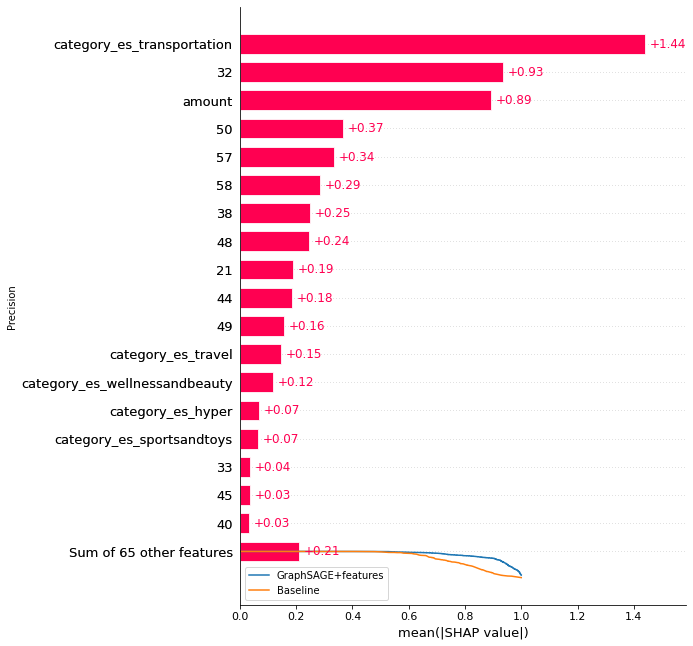

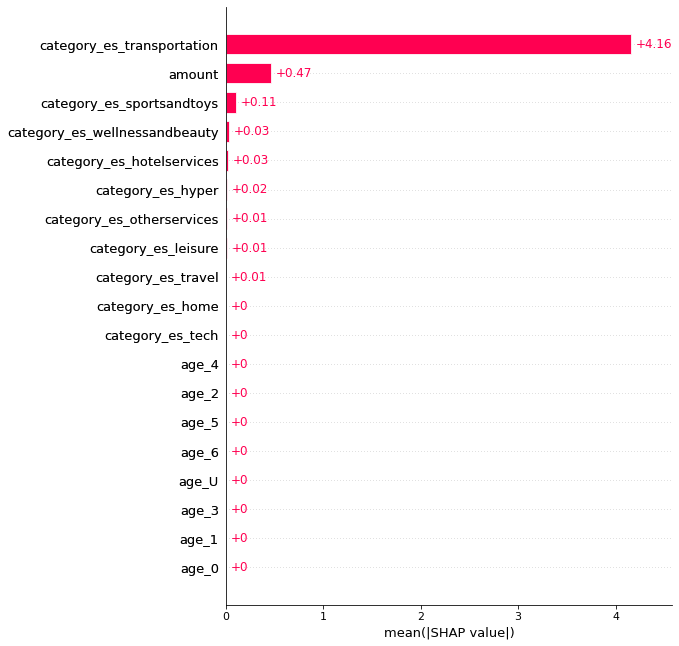

Epoch 1/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0487 - val_loss: 0.0346
Epoch 2/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0237 - val_loss: 0.0216
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.9162833459
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 895
Number of baseline only transactions: 46
Number of GraphSAGE+features only transactions: 141

Total number of TP transactions identified: 1082
Percentage of overlapping transactions: 82.71719038817005
Percentage of baseline only transactions: 4.251386321626617
Percentage of GraphSAGE+Features only transactions: 13.031423290203326

Value of overlapping transactions: 708052.8199999996
Value of baseline only transactions: 18863.460000000003
Value of GraphSAGE+features transactions: 29136.37000000001

% Value of overlapping transactions: 93.65125828207863
% Value of basel

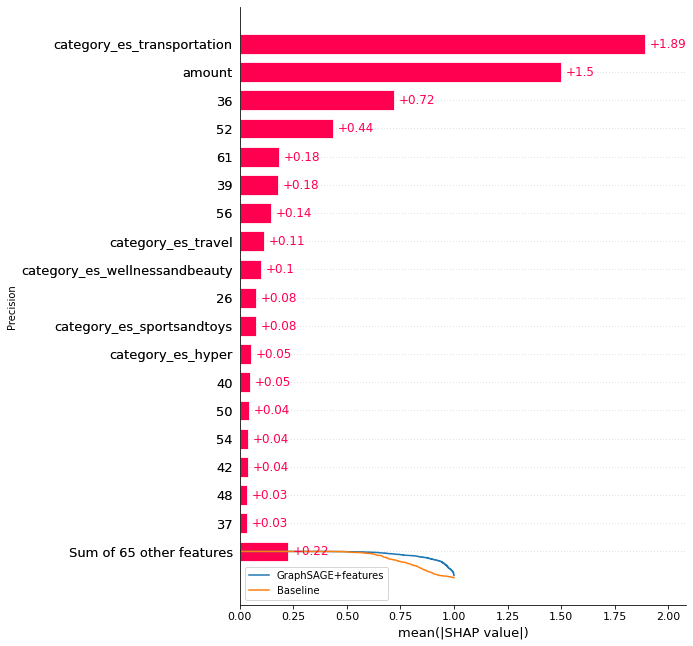

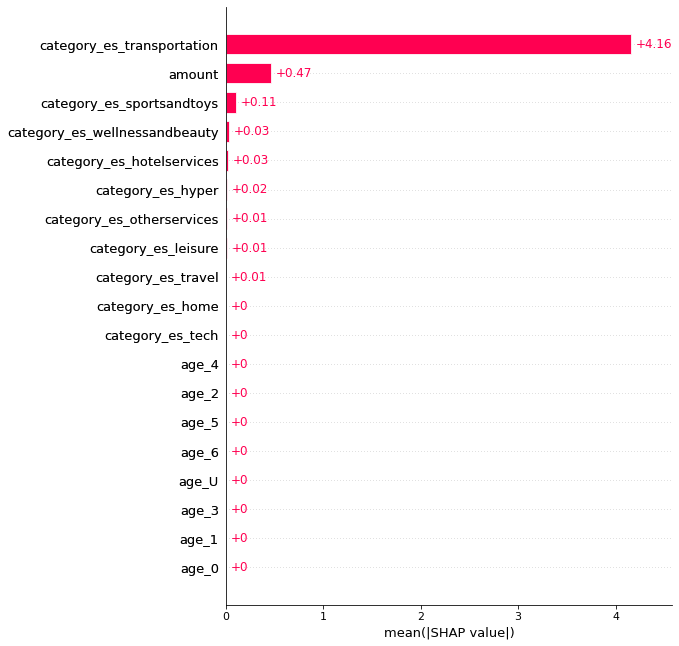

Epoch 1/3
72070/72070 [==============================] - 251s 3ms/step - loss: 0.0496 - val_loss: 0.0215
Epoch 2/3
72070/72070 [==============================] - 267s 4ms/step - loss: 0.0238 - val_loss: 0.0145
Epoch 3/3
28842/28842 [==============================] - 74s 3ms/step
Average precision-recall score XGBoost: 0.9149573681
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 889
Number of baseline only transactions: 52
Number of GraphSAGE+features only transactions: 121

Total number of TP transactions identified: 1062
Percentage of overlapping transactions: 83.70998116760829
Percentage of baseline only transactions: 4.8964218455743875
Percentage of GraphSAGE+Features only transactions: 11.393596986817325

Value of overlapping transactions: 705207.6899999998
Value of baseline only transactions: 21708.59
Value of GraphSAGE+features transactions: 24550.320000000003

% Value of overlapping transactions: 93.84418282861807
% Value of baseline only

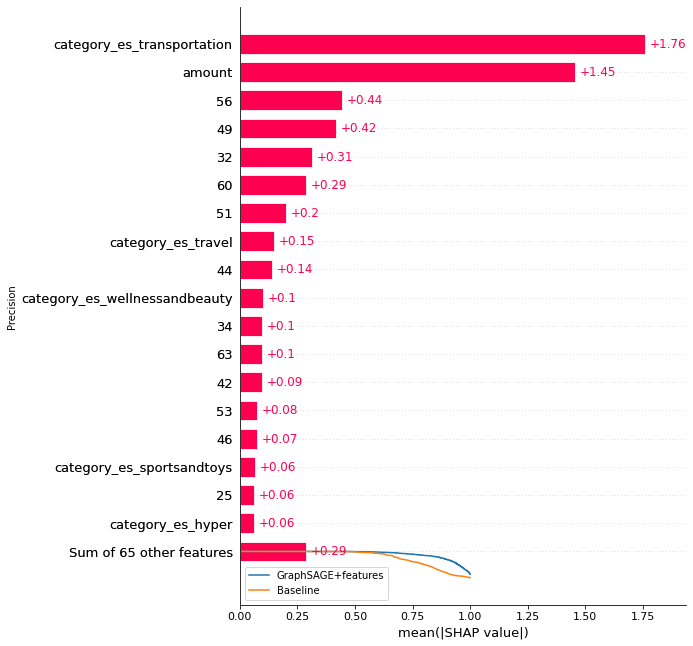

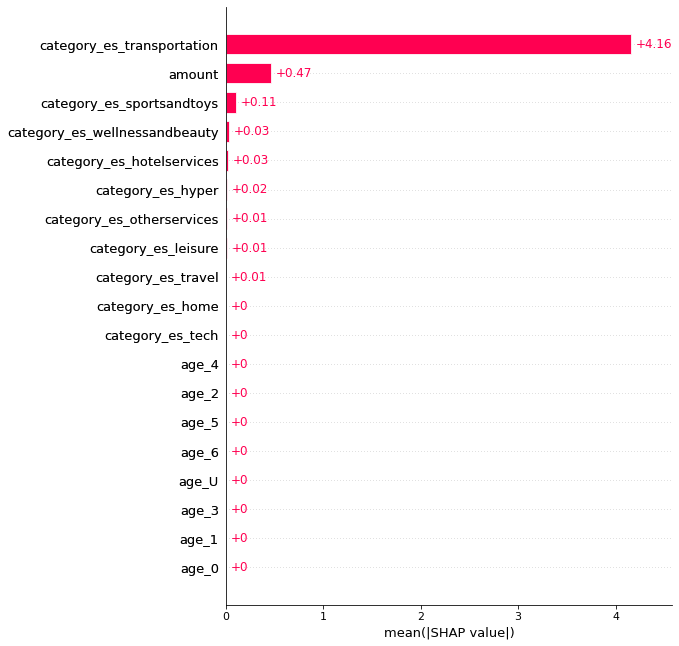

Epoch 1/3
72070/72070 [==============================] - 248s 3ms/step - loss: 0.0483 - val_loss: 0.0960
Epoch 2/3
72070/72070 [==============================] - 312s 4ms/step - loss: 0.0230 - val_loss: 0.0230
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.9145752094
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 860
Number of baseline only transactions: 81
Number of GraphSAGE+features only transactions: 96

Total number of TP transactions identified: 1037
Percentage of overlapping transactions: 82.93153326904532
Percentage of baseline only transactions: 7.81099324975892
Percentage of GraphSAGE+Features only transactions: 9.257473481195756

Value of overlapping transactions: 689182.1099999999
Value of baseline only transactions: 37734.17
Value of GraphSAGE+features transactions: 20512.619999999995

% Value of overlapping transactions: 92.20704604812578
% Value of baseline only tra

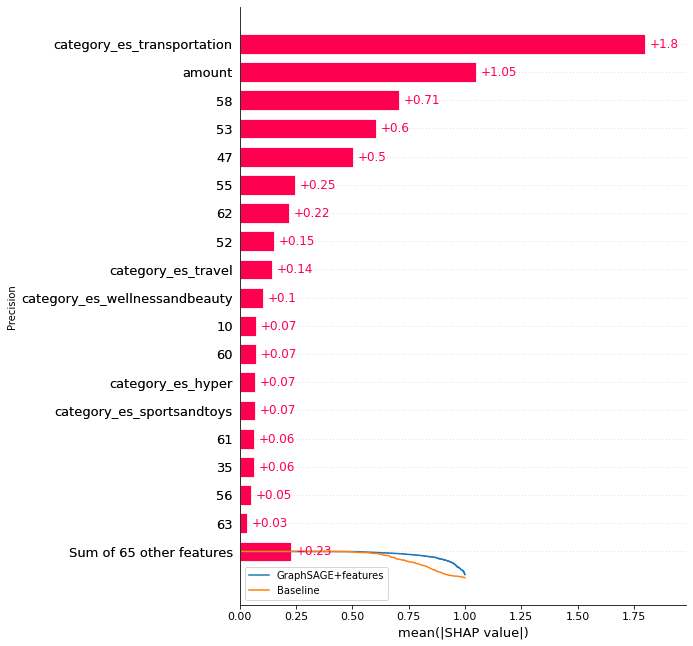

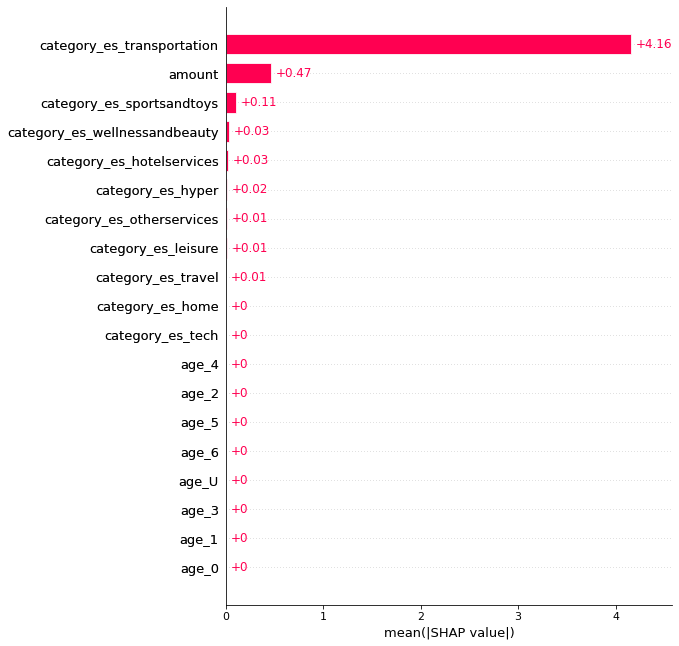

Epoch 1/3
72070/72070 [==============================] - 251s 3ms/step - loss: 0.0488 - val_loss: 0.0265
Epoch 2/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0232 - val_loss: 0.0156
Epoch 3/3
28842/28842 [==============================] - 73s 3ms/step
Average precision-recall score XGBoost: 0.8997055233
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 823
Number of baseline only transactions: 118
Number of GraphSAGE+features only transactions: 84

Total number of TP transactions identified: 1025
Percentage of overlapping transactions: 80.29268292682927
Percentage of baseline only transactions: 11.512195121951219
Percentage of GraphSAGE+Features only transactions: 8.195121951219512

Value of overlapping transactions: 687347.8199999998
Value of baseline only transactions: 39568.46
Value of GraphSAGE+features transactions: 17882.769999999997

% Value of overlapping transactions: 92.28634488725517
% Value of baseline only 

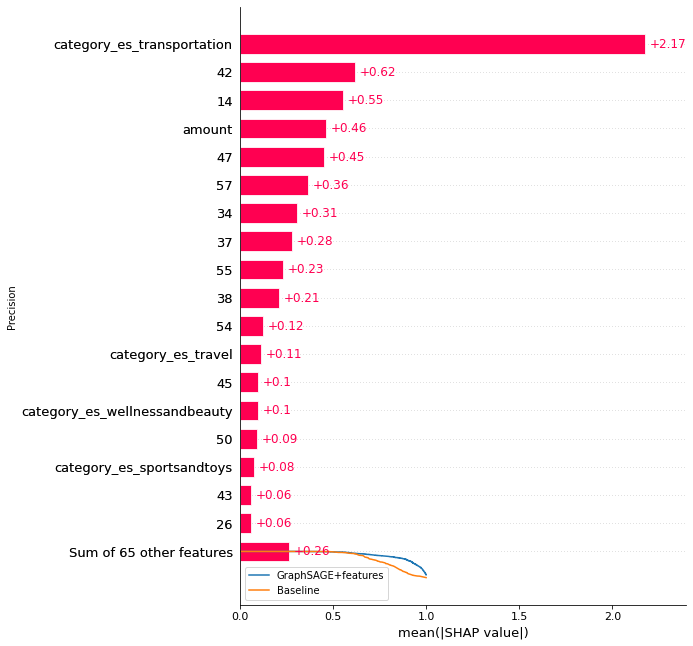

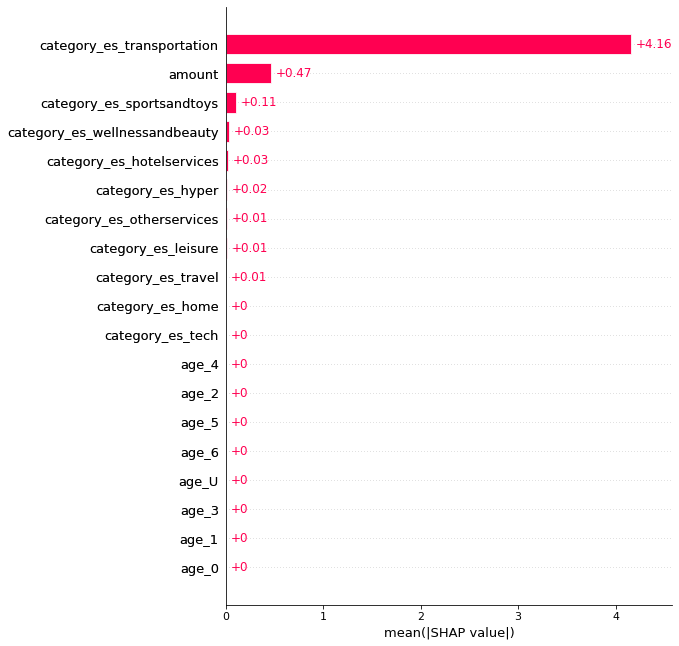

Epoch 1/3
72070/72070 [==============================] - 250s 3ms/step - loss: 0.0448 - val_loss: 0.0266
Epoch 2/3
72070/72070 [==============================] - 249s 3ms/step - loss: 0.0239 - val_loss: 0.0153
Epoch 3/3
28842/28842 [==============================] - 75s 3ms/step
Average precision-recall score XGBoost: 0.9027671700
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 843
Number of baseline only transactions: 98
Number of GraphSAGE+features only transactions: 92

Total number of TP transactions identified: 1033
Percentage of overlapping transactions: 81.60696999031946
Percentage of baseline only transactions: 9.486931268151016
Percentage of GraphSAGE+Features only transactions: 8.906098741529526

Value of overlapping transactions: 696753.1699999996
Value of baseline only transactions: 30163.110000000004
Value of GraphSAGE+features transactions: 17416.68

% Value of overlapping transactions: 93.60772764919612
% Value of baseline only tr

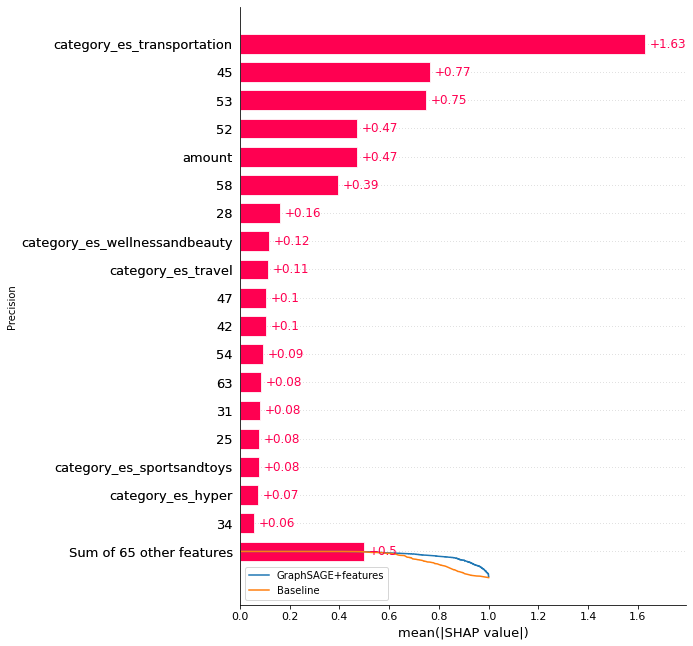

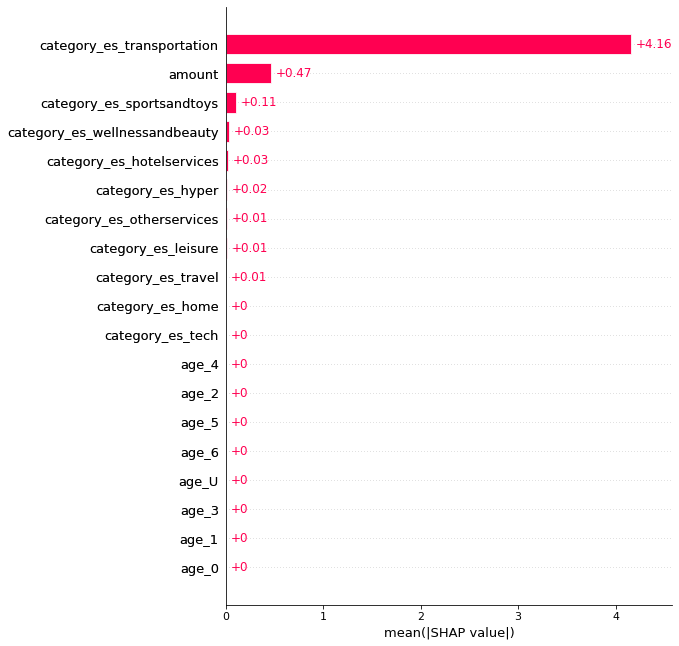

Epoch 1/3
72070/72070 [==============================] - 251s 3ms/step - loss: 0.0439 - val_loss: 0.0180
Epoch 2/3
72070/72070 [==============================] - 252s 3ms/step - loss: 0.0225 - val_loss: 0.0238
Epoch 3/3
28842/28842 [==============================] - 74s 3ms/step
Average precision-recall score XGBoost: 0.9058113382
Average precision-recall score XGBoost: 0.7933957870
Number of overlapping transactions: 850
Number of baseline only transactions: 91
Number of GraphSAGE+features only transactions: 99

Total number of TP transactions identified: 1040
Percentage of overlapping transactions: 81.73076923076923
Percentage of baseline only transactions: 8.75
Percentage of GraphSAGE+Features only transactions: 9.51923076923077

Value of overlapping transactions: 699591.0399999996
Value of baseline only transactions: 27325.24
Value of GraphSAGE+features transactions: 19706.79

% Value of overlapping transactions: 93.70069960468807
% Value of baseline only transactions: 3.6598440495

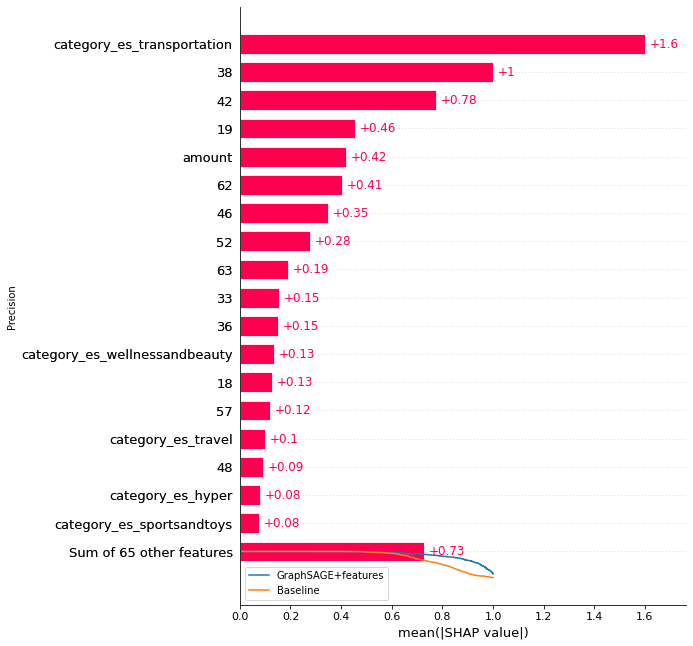

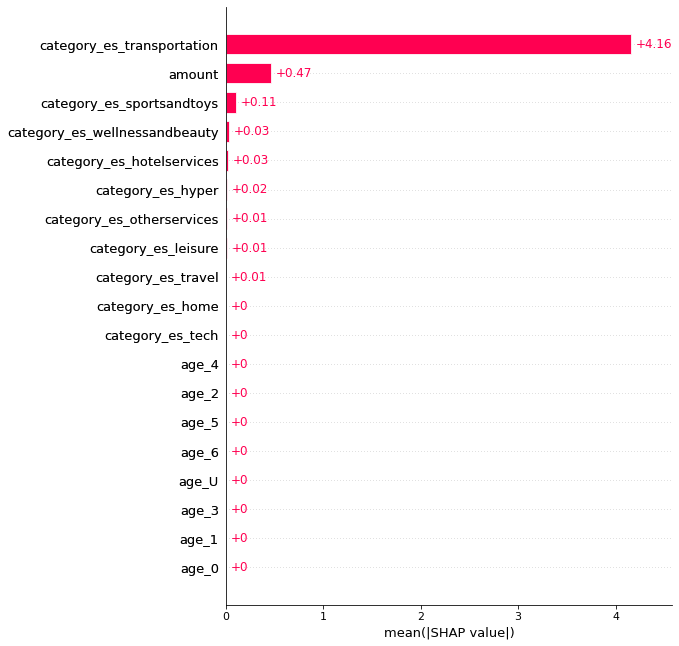

In [12]:
num_samples = [2, 32]
embedding_node_type = "transaction"

for i in range(10):
  hinsage = HinSAGE_Representation_Learner_ValueLoss(64, num_samples, embedding_node_type)

  inductive_labels, baseline_predictions, predictions, inductive_emb, train_emb_m, base_classifier, classifier, baseline_train = train_and_evaluate(start_train_time_step=0, end_train_time_step=140, start_test_time_step=141, end_test_time_step=180, epochs=3)
  both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes = tp_overlap_analysis(inductive_labels, np.argmax(baseline_predictions, axis=1), np.argmax(predictions, axis=1), inductive_graph_data)
  train_emb_m.columns = train_emb_m.columns.astype('str')

  explainer = shap.TreeExplainer(classifier)
  base_explainer = shap.TreeExplainer(base_classifier)

  base_shap_values = base_explainer(baseline_train)
  shap_values = explainer(train_emb_m)
  shap.plots.bar(shap_values, max_display=19)
  shap.plots.bar(base_shap_values, max_display=19)


## SHAP Values


In [8]:
train_emb_m.columns = train_emb_m.columns.astype('str')

explainer = shap.TreeExplainer(classifier)
base_explainer = shap.TreeExplainer(base_classifier)

base_shap_values = base_explainer(baseline_train)
shap_values = explainer(train_emb_m)


### GraphSAGE SHAP Values


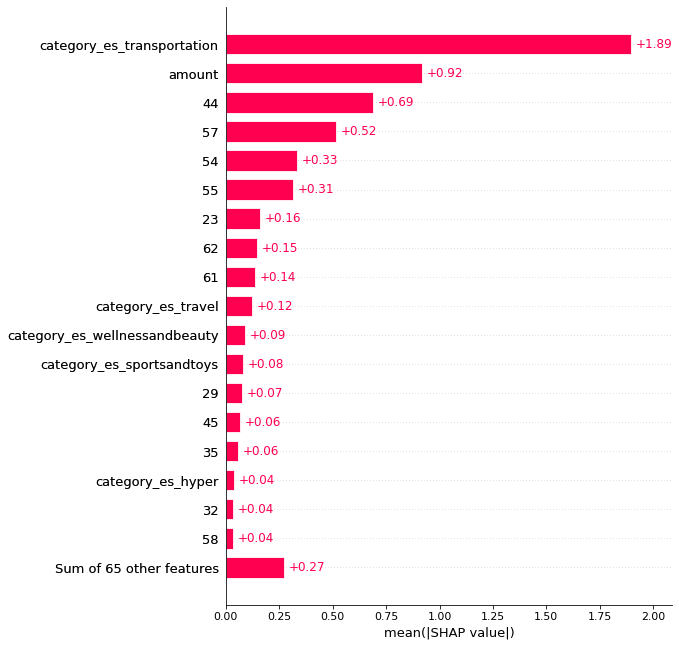

In [9]:
shap.plots.bar(shap_values, max_display=19)

### Baseline SHAP Values

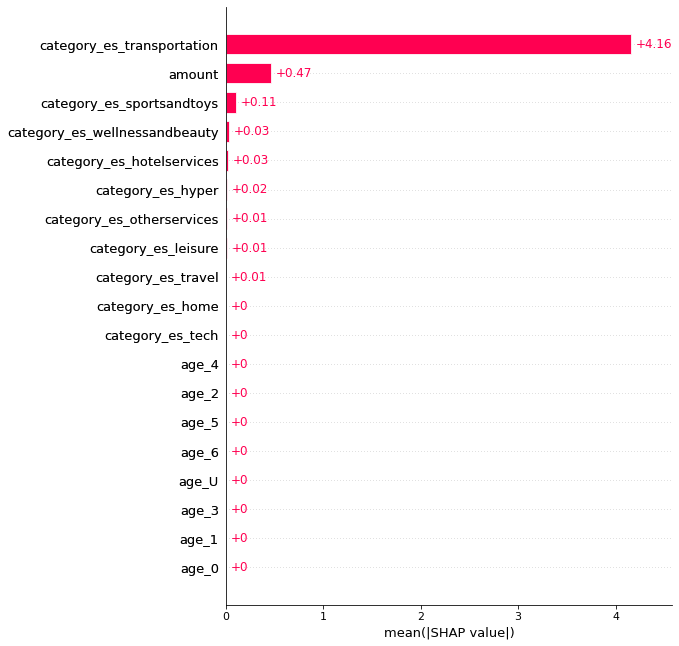

In [10]:
shap.plots.bar(base_shap_values, max_display=19)